# LFD Homework 6

Sixth week homework for the "Learning from Data" course offerd by [Caltech on edX](https://courses.edx.org/courses/course-v1:CaltechX+CS1156x+3T2017). Note that this notebook does not contain *all* solutions; it showcases solutions to those problems that require programming / simulation (and omits pen and paper problems).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import requests

%matplotlib notebook

## Regularization and Weight Decay (P2 - P6)

The data sets used in these problems can be found at

 * http://work.caltech.edu/data/in.dta
 * http://work.caltech.edu/data/out.dta

where `in.dta` corresponds to the training set and `out.dta` to the test set. In these files, each line contains a training example $(x_1, x_2, y)$ so that $\mathcal{X} = \mathbb{R}^2$ and $\mathcal{Y} = \{-1, 1\}$. The first step is to load that data:

In [2]:
def load_data():
    '''Loads the data directly from the caltech website.'''
    
    r = requests.get('http://work.caltech.edu/data/in.dta'); r.raise_for_status()
    data = np.loadtxt(r.content.splitlines())
    X, Y = np.split(data,[2], axis=-1)
    
    r = requests.get('http://work.caltech.edu/data/out.dta'); r.raise_for_status()
    data = np.loadtxt(r.content.splitlines())
    X_t, Y_t = np.split(data,[2], axis=-1)
    
    return X, Y, X_t, Y_t


X, Y, X_t, Y_t = load_data()

We are going to apply linear regression with a non-linear transformation for classification. The non-linear transformation is given by

$$
\Phi(x_1, x_2) = (1, x_1, x_2, x_1^2, x_2^2, x_1x_2, |x_1 - x_2|, |x_1 + x_2|)
$$

Recall that the classification error is defined as the fraction of misclassified points.

### P2

Run linear regression on the training set after performing the non-linear transformation. What values are closest (in Euclidean distance) to the in-sample and out-of-sample classification errors, respectively?

Here we can re-use the implementation of the linear regression classifier from `HW2`:

In [3]:
def Phi(X):
    x1, x2 = np.hsplit(X, 2)
    Z = np.concatenate((X, x1**2, x2**2, x1 * x2, np.abs(x1 - x2), np.abs(x1 + x2)), axis=1)
    return Z


class LRBClassifier:
    ''' Simple linear regression based binary classifier.'''
    
    def __init__(self, X, Y, lambd=0, add_intercept=True):       
        N, d = X.shape
        if add_intercept:
            X = np.concatenate((np.ones((N, 1)), X), axis=1)
            self.w = np.linalg.pinv(X.T @ X + lambd * np.eye(d+1)) @ (X.T) @ Y
        else:
            self.w = np.linalg.pinv(X.T @ X + lambd * np.eye(d)) @ (X.T) @ Y
            
        self.E_in = np.sum(self(X, add_intercept=False) != Y)/N
    
    def __call__(self, X, add_intercept=True):
        N, d = X.shape
        if add_intercept:
            X = np.concatenate((np.ones((N, 1)), X), axis=1)
        
        return np.sign(X @ self.w).reshape(-1,1)

    def E(self, X, Y, add_intercept=True):
        N, d = X.shape
        if add_intercept:
            X = np.concatenate((np.ones((N, 1)), X), axis=1)
            
        E = np.sum(Y != self(X, add_intercept=False)) / float(N)
        return E

Then, we can train this classifier on the training set and evaluate its out of sample error on the test set:

In [4]:
Z, Z_t = Phi(X), Phi(X_t)
g = LRBClassifier(Z, Y)
g.E_out = g.E(Z_t, Y_t)

print('Errors\n------\nE_in\t= {:.3f}\nE_out\t= {:.3f}'.format(g.E_in, g.E_out))

Errors
------
E_in	= 0.029
E_out	= 0.084


The closest (Euclidean distance) choice is then:

In [5]:
def choose_closest(choices, point, print_result=True):
    '''Choose the closest point to a given point (euclidean distance).'''
    
    distances = np.sqrt(np.sum((choices - point)**2, axis=0))
    idx = np.argmin(distances)
 
    if print_result:
        print('closest choice: ({:.3f}, {:.3f})\t--> ({})'.format(*choices[:, idx], 'abcde'[idx]))
        
    return choices[:, idx]
    

choose_closest (
    np.array([
        [.03, .03, .04, .04, .05],
        [.08, .10, .09, .11, .10]
    ]),
    np.array([[g.E_in], [g.E_out]])
);

closest choice: (0.030, 0.080)	--> (a)


### P3

Now we add weight decay to Linear Regression using $\lambda = 10^k$ for $k = -3$:

In [6]:
g = LRBClassifier(Z, Y, lambd=1e-3)
g.E_out = g.E(Z_t, Y_t)

print('Errors\n------\nE_in\t= {:.3f}\nE_out\t= {:.3f}'.format(g.E_in, g.E_out))

Errors
------
E_in	= 0.029
E_out	= 0.080


The closest (Euclidean distance) choice is then:

In [7]:
choose_closest (
    np.array([
        [.01, .02, .02, .03, .03],
        [.02, .04, .06, .08, .10]
    ]),
    np.array([[g.E_in], [g.E_out]])
);

closest choice: (0.030, 0.080)	--> (d)


### P4

Now we add weight decay to Linear Regression using $\lambda = 10^k$ for $k = 3$:

In [8]:
g = LRBClassifier(Z, Y, lambd=1e3)
g.E_out = g.E(Z_t, Y_t)

print('Errors\n------\nE_in\t= {:.3f}\nE_out\t= {:.3f}'.format(g.E_in, g.E_out))

Errors
------
E_in	= 0.371
E_out	= 0.436


The closest (Euclidean distance) choice is then:

In [9]:
choose_closest (
    np.array([
        [.2, .2, .3, .3, .4],
        [.2, .3, .3, .4, .4]
    ]),
    np.array([[g.E_in], [g.E_out]])
);

closest choice: (0.400, 0.400)	--> (e)


### P5

What value among the given choices achieves the smallest out-of-sample classification error?

In [10]:
def compute_E_out_for_k(choices):
    E_out = np.array([(lambda g: g.E(Z_t, Y_t))(LRBClassifier(Z, Y, lambd=10.**k)) for k in choices])
    return E_out


choices = np.array([2, 1, 0, -1, -2])
E_out = compute_E_out_for_k(choices)
idx = np.argmin(E_out)

print('closest choice: k={}\t--> ({})'.format(choices[idx], 'abcde'[idx]))    

closest choice: k=-1	--> (d)


### P6

What value is closest to the minimum out of sample error achieved by varying $k$ (limited to integer values)?

<IPython.core.display.Javascript object>


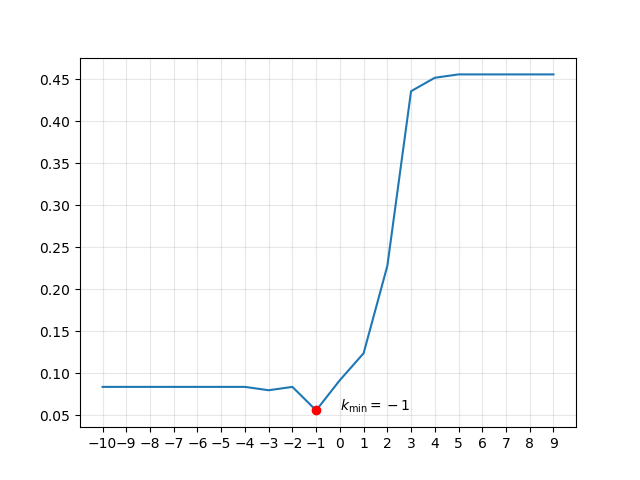

Results
-------
k_min	= -1
E_out	= 0.056


In [11]:
k = np.arange(-10, 10)
E_out = compute_E_out_for_k(k)
E_out_min = np.min(E_out)
k_min = k[np.argmin(E_out)]

plt.plot(k, E_out)
plt.plot(k_min, E_out_min, 'ro')
plt.text(k_min + 1, E_out_min, '$k_{\\min} = ' + str(k_min) + '$')
plt.xticks(k)
plt.grid(alpha=.3)

print('Results\n-------\nk_min\t= {}\nE_out\t= {:.3f}'.format(k_min, E_out_min))

## Neural Networks (P9 - P10)

While the compuation/exploration for these problems is better done on paper, the following method helps in counting connections (according to the definition given in the assignment) and thus exploring solutions. Let $d_l$ denote the number of nodes in layer $l \in \{0, \ldots, L-1\}$ and $d = (d_0, \ldots, d_{L-1}) \in \mathbb{N}^L$ the architecture of the network (to make the notation match, we start indexing the vector components from $0, \ldots, L-1$).

First, note that bias terms are counted as nodes here. The networks are fully connected, each unit of the previous layer (including its bias) has a connection to each unit of the current layer (excluding its bias). So in each layer, we have $d_{l-1}(d_l - 1)$ incoming conncetions. The final hidden layer is connceted to the single output node, so we have $d_{L-1}$ incoming connections there. This gives us

$$
c(d) = d_{L-1} + \sum_{l=1}^{L-1}{d_{l-1}(d_l - 1)}
$$

connections in the network. Now the constraint that we are given is that there are $36$ hidden nodes, which means that

$$
\sum_{l=1}^{L-1}d_l = 36
$$

Using this constraint and the fact that $d_0 = 10$, we can further simplify $c$ to obtain

$$
c(d) = 2d_{L-1} - 46 + \sum_{l=1}^{L-1}{d_{l-1}d_l}
$$

So the number of connections in a network with architecture $d$ is:

In [12]:
c = lambda d: 2*d[-1] - 46 + np.sum(d[:-1] * d[1:])

And the solution architectures for P9 and P10 respectively are:

In [13]:
arch_min = np.array([10] + 18*[2] + [1])
arch_max = np.array([10,22,14,1])
architectures = arch_min, arch_max

print('Solution\n--------\narch_min: {}\narch_max: {}\n--------\nc_min\t= {}\nc_max\t= {}'.format(
    *architectures,
    *[c(arch[:-1]) for arch in architectures]
))

Solution
--------
arch_min: [10  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  1]
arch_max: [10 22 14  1]
--------
c_min	= 46
c_max	= 510
